# Common Codes

In [14]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
from geojson import dumps
import geojson as g
%matplotlib inline
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import geoplotlib
import gmplot

In [4]:
def read_data(path, year):
    """
    reads csv data and returns 4 data frames for the given year
    input: path
    output: 4 data frames (station, status, trip, and weather)
    """
    path = path + '/' + str(year) + '/'
    station = pd.read_csv(path + 'station.csv')
    status = pd.read_csv(path + 'status.csv')
    trip = pd.read_csv(path + 'trip.csv')
    weather = pd.read_csv(path + 'weather.csv')
    
    return station, status, trip, weather

# ZAMIR'S CODES

In [5]:
path = '/Users/admin/project_data_141'
station, status, trip, weather = read_data(path, 2016)

In [6]:
print 'Size of station DF {}'.format(station.shape)
print 'Size of status DF {}'.format(status.shape)
print 'Size of trip DF {}'.format(trip.shape)
print 'Size of weather DF {}'.format(weather.shape)

Size of station DF (992, 7)
Size of status DF (35517185, 4)
Size of trip DF (313689, 11)
Size of weather DF (1830, 24)


In [8]:
trip = trip.rename(columns={'Start Terminal' : 'station_id'})
merged_st = pd.merge(station, trip, on = 'station_id')

### Statistics about bike rides

In [9]:
print 'number of bike rides between 09/01/2015 and 08/31/2016 : {}'.format(len(merged_st['Trip ID']))
print 'averaging about {} minutes per ride'.format(sum(merged_st.Duration)/(len(merged_st['Trip ID']) *60))
print 'total riding time is {} hours'.format(sum(merged_st.Duration)/3600)

number of bike rides between 09/01/2015 and 08/31/2016 : 312126
averaging about 13 minutes per ride
total riding time is 71729 hours


### trip counts by subscription types

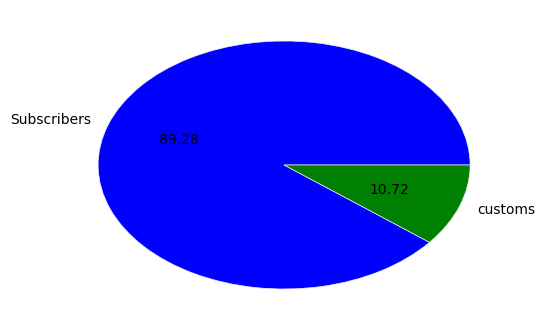

In [18]:
by_types = merged_st['Subscriber Type'].value_counts()
_ = plt.pie(by_types, labels= ['Subscribers', 'customs'], autopct= '%.2f')
#plt.savefig('./Pictures/by_types.png') #run it only once

### trip counts by cities

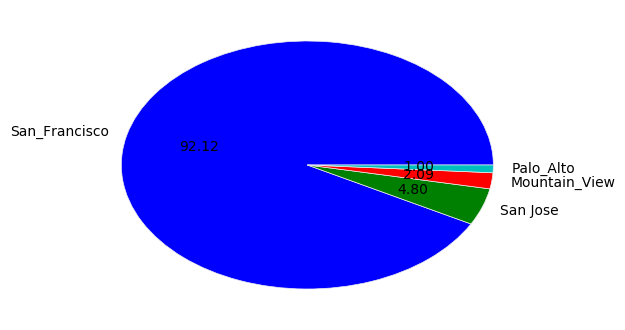

In [20]:
by_cities = merged_st.landmark.value_counts()
_ = plt.pie(by_cities, labels=['San_Francisco', 'San Jose', 'Mountain_View', 'Palo_Alto'], autopct='%.2f')
#plt.savefig('./Pictures/by_cities.png') #run it only once

### most popular five starting stations

In [19]:
merged_st.name.value_counts()[:5]

San Francisco Caltrain (Townsend at 4th)    23591
San Francisco Caltrain 2 (330 Townsend)     22358
Harry Bridges Plaza (Ferry Building)        16128
2nd at Townsend                             14099
Steuart at Market                           13693
Name: name, dtype: int64

<h3> Bay Area Bike Share map </h3>
To get better sense of Bike Stations, let's create station maps. To this end, I am creating the geoJSON file which I later transfer to gist and create an interactive plot.

In [23]:
def parser(df):
    """
    Parses a pandas DF into JSON-line object
    input: a dataframe
    output: JSON-line object
    """
    fields = df.columns
    parsed_data = (dict(zip(fields, df.iloc[i])) for i in xrange(len(df)))
    return parsed_data


def create_map(df):
    """
    Creates a map for the given data frame
    input: a data frame
    output: a message: "geoJSON file has been created, check out your cd"
    """
    
    geo_map = {'type': 'FeatureCollection'}
    items = list()
    for index, line in enumerate(parser(df)):
        #Skip any zero coordinates as this will throw off our map
        if line['long'] == str(0) or line['lat'] == str(0):
            continue
        
        data = {}
        data['type'] = 'Feature'
        data['id'] = index
        year = line['installation'].split('/')[2]
        if line['station_id'] == 70 or line['station_id'] == 69:
            data['properties'] = {'name': line['name'],
                             'dockcount': line['dockcount'],
                          'trip_counts' : line['trip_counts'],
                          'marker-color':'#a11f27'
                                 }
        elif year == '2013':
            data['properties'] = {'name': line['name'],
                             'dockcount': line['dockcount'],
                          'trip_counts' : line['trip_counts'],
                          'marker-color':'#0e2f44'
                                 }
        else:
            data['properties'] = {'name': line['name'],
                             'dockcount': line['dockcount'],
                          'trip_counts' : line['trip_counts']
                                 }
        data['geometry'] = {'type': 'Point',
                     'coordinates': (line['long'], line['lat'])
                          }
        items.append(data)
    #for each point in our items, we add the point to our dictionary
    for point in items:
        geo_map.setdefault('features', []).append(point)

    #Now that we've build up our geo_map dictionary, let's save it as geojson file
    with open('sfbikestations.geojson', 'w') as f:
            f.write(dumps(geo_map))
    return "geoJSON file has been created, check out your cd"

In [21]:
trip_counts = pd.DataFrame(merged_st.sort_values(by = 'station_id').station_id.value_counts())
trip_counts = trip_counts.reset_index().rename(columns = {'station_id' : 'trip_counts',
                                                          'index' : 'station_id'})
station_merged = pd.merge(station, trip_counts, on = 'station_id')
station_merged.columns

Index([u'station_id', u'name', u'lat', u'long', u'dockcount', u'landmark',
       u'installation', u'trip_counts'],
      dtype='object')

In [24]:
create_map(station_merged)

'geoJSON file has been created, check out your cd'

Now, use the newly created geoJSON file and create a map with https://gist.github.com

####The map can be seen only in HTML formatted file
script src="https://gist.github.com/akimbekov/557babc67daed3b6a40b75c0e88dda33.js"></script

# ASHKAN'S CODES

<h3>Read the data</h3>

In [10]:
path = '../Project_Datasets'

In [11]:
station, status, trip, weather = read_data(path, 2016)

<h3>Plot stations on map</h3>

In [12]:
def plot_station(df, city):
    '''
    This function plots the stations available in each city
    @args:
        df: is the data frame containing the stations information such as their name and latitude and longitudes
        city: name of city of intrests among: San Jose, San Francisco, Palo Alto, Mountain View
    @returns:
        a map plot of stations
    '''
    path = '/Users/ashkansaboori/Documents/OneDrive/MyPhD/Courses/5 Winter-2017/STA 141B/Project/SF_bike_share/Pictures/'
    file_name = path + city + '_map'
    df = df[df.landmark == city]
    data = df[['name', 'lat', 'long']].dropna()
    data = data.rename(columns={'long':'lon'})
    geoplotlib.dot(data, point_size=4)
    #geoplotlib.show()
    return geoplotlib.savefig(file_name)

In [17]:
plot_station(station, 'San Francisco')

<h3>Plot trips on map</h3>

In [27]:
def plot_trip(station, trip, city):
    '''
    This function plots the 
    '''
    
    path = '/Users/ashkansaboori/Documents/OneDrive/MyPhD/Courses/5 Winter-2017/STA 141B/Project/SF_bike_share/Pictures/'
    file_name = path + city + '_trips'
    
    station = station[station.landmark == city]
    start_trip_end = trip[['Start Station', 'End Station']].drop_duplicates().dropna()
    #Remove trips that start and end stations are the same
    start_trip_end = start_trip_end[~(start_trip_end['Start Station'] == start_trip_end['End Station'])]
    start_trip = pd.DataFrame(start_trip_end['Start Station'])
    end_trip = pd.DataFrame(start_trip_end['End Station'])

    start_trip_end = pd.merge(left = station[['name', 'lat', 'long']], right = start_trip_end, how = 'inner', left_on='name', right_on='Start Station')
    start_trip_end = start_trip_end.rename(columns = {'long': 'lon_departure', 'lat': 'lat_departure'})
    
    start_trip_end = pd.merge(left = station[['name', 'lat', 'long']], right = start_trip_end, how = 'inner', left_on='name', right_on='End Station')
    start_trip_end = start_trip_end.rename(columns = {'long': 'lon_arrival', 'lat': 'lat_arrival'})
    start_trip_end = start_trip_end[['lon_departure', 'lat_departure', 'lon_arrival', 'lat_arrival']]
    
    geoplotlib.graph(start_trip_end,
                 src_lat='lat_departure',
                 src_lon='lon_departure',
                 dest_lat='lat_arrival',
                 dest_lon='lon_arrival',
                 color='hot_r',
                 alpha=16,
                 linewidth=3)
    return geoplotlib.savefig(file_name)

In [29]:
plot_trip(station, trip, 'Mountain View')

<h3>Station trip count</h3>

In [ ]:
def OneTrip_count(stationDF, tripDF, tripType):
    '''
    This function computes the number of departure or arrival trip for each station
    @args:
        staionDF: station dataframe
        tripDF: trip dataframe
        tripType: which shows whether is departure or arrival. The value could be: "Start Terminal" or "End Terminal"
    @returns:
        a dataframe containing the number of trip and dock for each station
    '''
    
    if tripType == 'Start Terminal':
        count = 'departure_count'
    else:
        count = 'arrival_count'
        
    dockCount = stationDF[['station_id', 'name', 'dockcount']]
    tripCount = tripDF.groupby(tripType).agg(['count'])['Trip ID']
    #Convert the index to column
    tripCount.reset_index(level=0, inplace=True)
    tripCount=tripCount.rename(columns = {tripType: 'station_id', 'count': count})
    result = pd.merge(left = dockCount, right = tripCount, how = 'inner', on= 'station_id')
    return result

In [ ]:
def TwoTrip_count(stationDF, tripDF):
    '''
    This function computes the number of both departure and arrival trips for each station
    @args:
        staionDF: station dataframe
        tripDF: trip dataframe
    @returns:
        a dataframe containing the number of trip and dock for each station
    '''
    
    tripCount =pd.merge(left=OneTrip_count(stationDF, tripDF,'Start Terminal'), 
                        right=OneTrip_count(stationDF, tripDF,'End Terminal'), 
                    on=['station_id', 'dockcount'], how='inner')
    del tripCount['name_y']
    tripCount = tripCount.rename(columns={'name_x': 'station name'})
    return tripCount.sort_values('station_id')

In [ ]:
TwoTrip_count(station, trip)

# PAM'S CODES

In [3]:
path = '~/Dropbox/141B/Project/data'

In [4]:
station15, status15, trip15, weather15 = read_data(path, 2015)

In [5]:
station15.head()

,station_id,name,lat,long,dockcount,landmark,installation
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [6]:
status15.head()

,station_id,bikes_available,docks_available,time
0,2,15,12,2014-09-01 00:00:03
1,2,15,12,2014-09-01 00:01:02
2,2,15,12,2014-09-01 00:02:02
3,2,15,12,2014-09-01 00:03:03
4,2,15,12,2014-09-01 00:04:02


In [7]:
trip15.head()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code
0,913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139
1,913459,1036,8/31/2015 23:11,San Antonio Shopping Center,31,8/31/2015 23:28,Mountain View City Hall,27,35,Subscriber,95032
2,913455,307,8/31/2015 23:13,Post at Kearny,47,8/31/2015 23:18,2nd at South Park,64,468,Subscriber,94107
3,913454,409,8/31/2015 23:10,San Jose City Hall,10,8/31/2015 23:17,San Salvador at 1st,8,68,Subscriber,95113
4,913453,789,8/31/2015 23:09,Embarcadero at Folsom,51,8/31/2015 23:22,Embarcadero at Sansome,60,487,Customer,9069


In [8]:
weather15.head()

,PDT,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,9/1/2014,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0,0.0,NaN,290.0,94107
1,9/2/2014,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0,5.0,NaN,290.0,94107
2,9/3/2014,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0,4.0,NaN,276.0,94107
3,9/4/2014,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0,5.0,NaN,301.0,94107
4,9/5/2014,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0,4.0,NaN,309.0,94107


In [9]:
station15['year']='2015'
status15['year'] = '2015'
trip15['year'] = '2015'
weather15['year'] = '2015'

In [12]:
trip15['Count'] = 1
trip15['Date'] = ''

In [13]:
trip15['Date'] = trip15.apply(lambda x:  x.loc[('Start Date')].split()[0], axis=1)

In [14]:
trip15.head()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code,year,Count,Date
0,913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139,2015,1,8/31/2015
1,913459,1036,8/31/2015 23:11,San Antonio Shopping Center,31,8/31/2015 23:28,Mountain View City Hall,27,35,Subscriber,95032,2015,1,8/31/2015
2,913455,307,8/31/2015 23:13,Post at Kearny,47,8/31/2015 23:18,2nd at South Park,64,468,Subscriber,94107,2015,1,8/31/2015
3,913454,409,8/31/2015 23:10,San Jose City Hall,10,8/31/2015 23:17,San Salvador at 1st,8,68,Subscriber,95113,2015,1,8/31/2015
4,913453,789,8/31/2015 23:09,Embarcadero at Folsom,51,8/31/2015 23:22,Embarcadero at Sansome,60,487,Customer,9069,2015,1,8/31/2015


In [16]:
total_rides15 = trip15[['Count', 'Date']]
total_rides15 = total_rides15.set_index('Date')
total_rides15 = total_rides15.groupby(level = 0).sum()

In [17]:
total_rides15.head()

,Count
Date,
1/1/2015,181
1/10/2015,362
1/11/2015,327
1/12/2015,1344
1/13/2015,1368


In [18]:
weather15 = weather15.rename(index=str, columns={'PDT': 'Date',})

In [19]:
weather15.head(1)

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip,year
0,9/1/2014,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,8.0,16.0,7.0,20.0,0,0.0,NaN,290.0,94107,2015


In [20]:
weather15 = weather15.set_index('Date')

In [21]:
weather15 = weather15.set_index('Zip', append = True)

In [22]:
weather15.shape

(1825, 23)

In [23]:
weather15.xs('9/1/2014', level = 'Date')

,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressureIn,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,year
Zip,,,,,,,,,,,,,,,,,,,,,
94107,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,29.86,...,10.0,8.0,16.0,7.0,20.0,0,0.0,NaN,290.0,2015
94063,89.0,74.0,60.0,64.0,56.0,52.0,82.0,67.0,27.0,29.86,...,10.0,10.0,12.0,2.0,NaN,0,0.0,NaN,339.0,2015
94301,86.0,72.0,57.0,66.0,63.0,55.0,94.0,69.0,43.0,29.86,...,10.0,10.0,17.0,6.0,22.0,0,0.0,NaN,351.0,2015
94041,85.0,73.0,60.0,60.0,58.0,53.0,84.0,59.0,34.0,29.87,...,10.0,10.0,17.0,5.0,21.0,0,0.0,NaN,342.0,2015
95113,86.0,72.0,58.0,60.0,54.0,50.0,86.0,59.0,31.0,29.86,...,10.0,10.0,17.0,5.0,22.0,0,0.0,NaN,296.0,2015


In [24]:
weather15['PrecipitationIn'] = pd.to_numeric(weather15['PrecipitationIn'].replace('T', 0))

In [25]:
weather15ave = weather15.groupby(level = 'Date').mean()

In [26]:
weather15ave.head()

,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressureIn,...,Min Sea Level PressureIn,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees
Date,,,,,,,,,,,,,,,,,,,,,
1/1/2015,55.0,44.6,34.0,29.6,24.0,17.8,65.6,45.4,25.2,30.182,...,30.084,10.0,10.0,10.0,12.0,3.8,18.000000,0.000,0.4,228.2
1/10/2015,59.8,53.8,47.4,52.0,48.6,45.6,97.2,84.8,69.0,30.054,...,29.960,10.0,7.4,4.2,8.2,3.0,9.333333,0.000,4.2,309.8
1/11/2015,56.0,50.2,44.0,50.2,47.4,43.4,99.2,91.2,80.2,30.186,...,30.038,9.8,5.4,0.4,9.0,2.2,17.333333,0.000,4.6,196.8
1/12/2015,60.4,51.8,43.0,50.6,46.4,42.0,98.4,84.6,64.6,30.282,...,30.196,10.0,8.6,5.2,8.4,2.0,11.666667,0.004,1.4,252.6
1/13/2015,64.2,53.6,42.6,48.0,43.0,37.8,100.0,70.2,40.0,30.230,...,30.118,10.0,7.4,4.0,14.0,3.0,22.000000,0.000,1.4,176.4


In [27]:
weather15ave.index.values == total_rides15.index.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [28]:
converter = lambda d: matplotlib.dates.datestr2num(d)
vfun = np.vectorize(converter)

In [29]:
num_dates = vfun(weather15ave.index.values)

In [30]:
weather15ave['num_dates'] = num_dates.tolist()

In [31]:
total_rides15['num_dates'] = num_dates.tolist()

In [32]:
total_rides15 = total_rides15.sort_values(by = 'num_dates', ascending = True)

In [33]:
weather15ave = weather15ave.sort_values(by = 'num_dates', ascending = True)

In [34]:
def weather_plot(y1,y2, y2_label):
    """
    Returns dual axis plot with the x axis being the day, the left and right y-axis being inputed by user
    input: y1 is the data for the left-axis; should have 365 entries, sorted by date;
    y2 is the data for the right y-axis; should have 365 entries, sorted by date; 
    y2_label is a string
    output: a graph
    """
    fig, ax1 = plt.subplots(figsize = (15,5))
    x = total_rides15['num_dates']
    #y1 = total_rides15['Count']
    ax1.plot(x, y1, 'b-')
    ax1.set_xlabel('Day')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Total Rides', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    #y2 = weather15ave[y2_label]
    ax2.plot(x, y2, 'r.')
    ax2.set_ylabel(y2_label, color='r')
    ax2.tick_params('y', colors='r')

    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%y'))
    #fig.tight_layout()
    return plt.show()

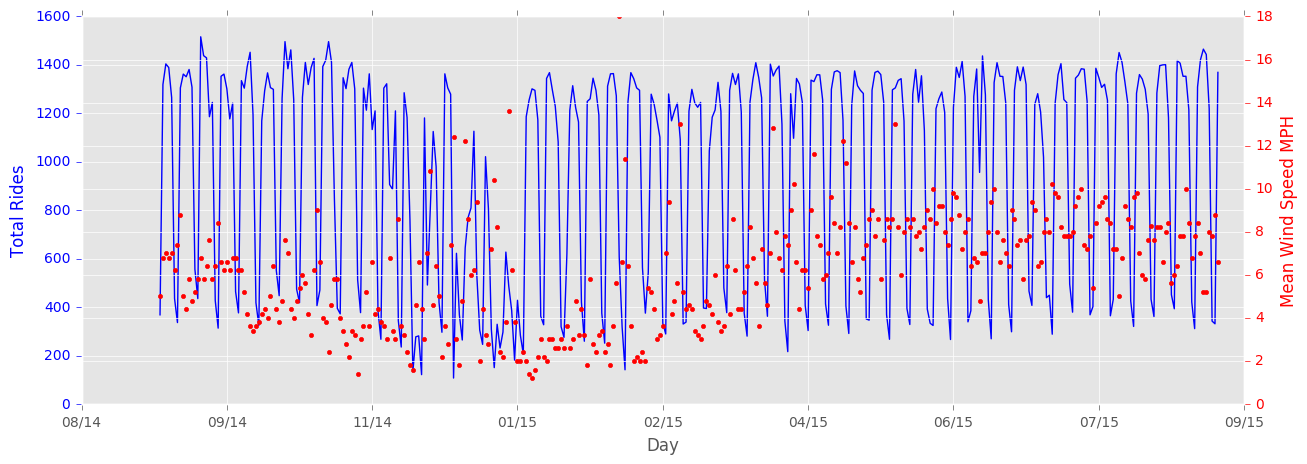

In [35]:
weather_plot(total_rides15['Count'], weather15ave[' Mean Wind SpeedMPH'], 'Mean Wind Speed MPH')

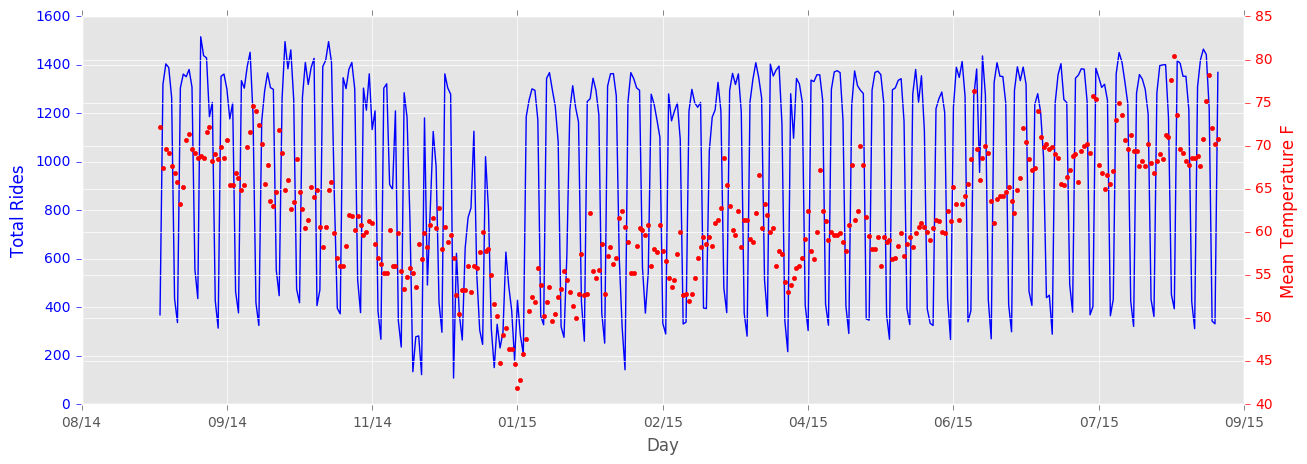

In [36]:
weather_plot(total_rides15['Count'],weather15ave['Mean TemperatureF'], 'Mean Temperature F')

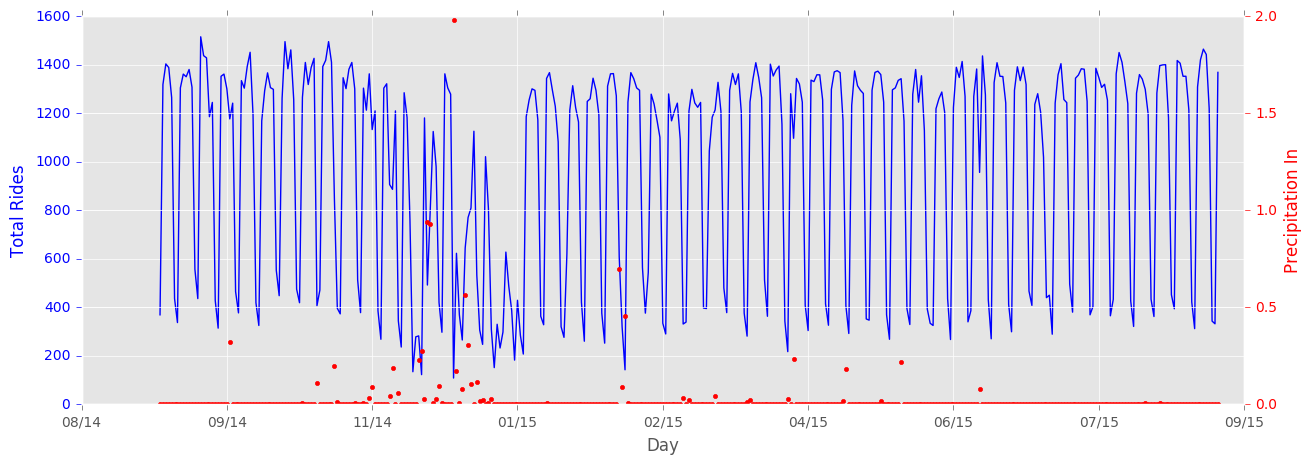

In [37]:
weather_plot(total_rides15['Count'],weather15ave['PrecipitationIn'], 'Precipitation In')

In [38]:
weather15ave.columns.values

array(['Max TemperatureF', 'Mean TemperatureF', 'Min TemperatureF',
       'Max Dew PointF', 'MeanDew PointF', 'Min DewpointF', 'Max Humidity',
       ' Mean Humidity', ' Min Humidity', ' Max Sea Level PressureIn',
       ' Mean Sea Level PressureIn', ' Min Sea Level PressureIn',
       ' Max VisibilityMiles', ' Mean VisibilityMiles',
       ' Min VisibilityMiles', ' Max Wind SpeedMPH', ' Mean Wind SpeedMPH',
       ' Max Gust SpeedMPH', 'PrecipitationIn', ' CloudCover',
       ' WindDirDegrees', 'num_dates'], dtype=object)

In [39]:
weather15.columns.values

array(['Max TemperatureF', 'Mean TemperatureF', 'Min TemperatureF',
       'Max Dew PointF', 'MeanDew PointF', 'Min DewpointF', 'Max Humidity',
       ' Mean Humidity', ' Min Humidity', ' Max Sea Level PressureIn',
       ' Mean Sea Level PressureIn', ' Min Sea Level PressureIn',
       ' Max VisibilityMiles', ' Mean VisibilityMiles',
       ' Min VisibilityMiles', ' Max Wind SpeedMPH', ' Mean Wind SpeedMPH',
       ' Max Gust SpeedMPH', 'PrecipitationIn', ' CloudCover', ' Events',
       ' WindDirDegrees', 'year'], dtype=object)